In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
from pathlib import Path

from openpyxl.styles.builtins import title
from torch.backends.cudnn import allow_tf32

plot_folder = Path('/Users/jg/Desktop/upper_limb/paper_figures')

In [ ]:
participants = ['P_149', 'P_238', 'P_407', 'P_426', 'P_577', 'P_668', 'P_711', 'P_950']
data_folder = Path('/Users/jg/Desktop/upper_limb/paper_data')
plot_folder = Path('/Users/jg/Desktop/upper_limb/paper_figures')

#make df using the participants as index
df = pd.DataFrame(index=participants, columns=pd.MultiIndex.from_product([['init', 'offline'], ['val', 'test', 'total']]))
df.loc[:, 'participants'] = df.index



      init            offline            participants
       val test total     val test total             
P_149  NaN  NaN   NaN     NaN  NaN   NaN        P_149
P_238  NaN  NaN   NaN     NaN  NaN   NaN        P_238
P_407  NaN  NaN   NaN     NaN  NaN   NaN        P_407
P_426  NaN  NaN   NaN     NaN  NaN   NaN        P_426
P_577  NaN  NaN   NaN     NaN  NaN   NaN        P_577
P_668  NaN  NaN   NaN     NaN  NaN   NaN        P_668
P_711  NaN  NaN   NaN     NaN  NaN   NaN        P_711
P_950  NaN  NaN   NaN     NaN  NaN   NaN        P_950


In [42]:
# init
mapping = pd.read_csv(data_folder / 'offline_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'init')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'init'), inplace=True)

# val
data = pd.read_csv(data_folder / 'offline_val_loss.csv')
for key in df.index:
    df.loc[key, ('init', 'val')] = data.loc[0, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'offline_test_loss.csv')
for key in df.index:
    df.loc[key, ('init', 'test')] = data.loc[0, f'{key} - total_test_loss']
    
# total
df.loc[:, ('init', 'total')] = (df.loc[:, ('init', 'val')] * 9 + df.loc[:, ('init', 'test')] * 3) / 12


In [43]:
# offline
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'offline_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'offline')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'offline'), inplace=True)

# val
data = pd.read_csv(data_folder / 'offline_val_loss.csv')
for key in df.index:
    df.loc[key, ('offline', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'offline_test_loss.csv')
for key in df.index:
    df.loc[key, ('offline', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('offline', 'total')] = (df.loc[:, ('offline', 'val')] * 9 + df.loc[:, ('offline', 'test')] * 3) / 12

In [44]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with independent y-axis limits
fig, axes = plt.subplots(1, 3, figsize=(18*0.7, 5*0.7), sharey=True)

# Set index
df.set_index('participants', inplace=True, drop=False)

# Modes to plot
modes = ['val', 'test', 'total']
names = ['Known Movements', 'New Movements', 'All Movements']

# Plot each mode in a separate subplot
for idx, (ax, mode) in enumerate(zip(axes, modes)):
    for participant in participants:
        ax.plot(['Before', 'After'], 
                [df.loc[participant, ('init', mode)], df.loc[participant, ('offline', mode)]], 
                label=participant)
    name = 'Validation' if mode == 'val' else 'Test' if mode == 'test' else 'Total'
    ax.set_title(names[idx], fontweight='bold')
    
    # Set ylabel only for the first subplot
    if idx == 0:
        ax.set_ylabel('MSE')

    # Add legend only to the last subplot
    if idx == 2:  # Last subplot
        ax.legend(loc='upper right', title='Participants', title_fontproperties={'weight':'bold'})
    ax.set_xlabel('Online Training')




# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig(plot_folder / 'individual.png', dpi=300) 
plt.close(fig)

In [45]:
# pert_init
mapping = pd.read_csv(data_folder / 'pert_offline_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'pert_init')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'pert_init'), inplace=True)

# val
data = pd.read_csv(data_folder / 'pert_offline_val_loss.csv')
for key in df.index:
    df.loc[key, ('pert_init', 'val')] = data.loc[0, f'{key} - total_val_loss']

# test
data = pd.read_csv(data_folder / 'pert_offline_test_loss.csv')
for key in df.index:
    df.loc[key, ('pert_init', 'test')] = data.loc[0, f'{key} - total_test_loss']

# total
df.loc[:, ('pert_init', 'total')] = (df.loc[:, ('pert_init', 'val')] * 9 + df.loc[:, ('pert_init', 'test')] * 3) / 12


In [46]:
# pert_offline
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'pert_offline_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'pert_offline')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'pert_offline'), inplace=True)

# val
data = pd.read_csv(data_folder / 'pert_offline_val_loss.csv')
for key in df.index:
    df.loc[key, ('pert_offline', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'pert_offline_test_loss.csv')
for key in df.index:
    df.loc[key, ('pert_offline', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('pert_offline', 'total')] = (df.loc[:, ('pert_offline', 'val')] * 9 + df.loc[:, ('pert_offline', 'test')] * 3) / 12

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Create a figure and a single set of axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set index
df.set_index('participants', inplace=True, drop=False)

# Modes to plot
modes = ['val', 'test', 'total']
colors = ['blue', 'green', 'red']  # Different colors for each mode
labels = ['Known Movements', 'New Movements', 'All Movements']  # Labels for each mode

# X positions for 'before' and 'after'
x_positions = np.arange(2)  # Positions for 'before' and 'after'
bar_width = 0.02  # Used for shifting

# Create a list to store custom legend handles
custom_legend_handles = []
custom_legend_handles2 = []


# Plot each mode on the same axes
for idx, (mode, color, label) in enumerate(zip(modes, colors, labels)):
    # Extract data
    means_before = []
    means_after = []

    for participant in participants:
        means_before.append(df.loc[participant, ('pert_init', mode)])
        means_after.append(df.loc[participant, ('pert_offline', mode)])

    # Convert lists to numpy arrays
    means_before = np.array(means_before)
    means_after = np.array(means_after)

    # Calculate mean and std for plotting
    mean_before = np.mean(means_before)
    mean_after = np.mean(means_after)
    std_before = np.std(means_before)
    std_after = np.std(means_after)

    # Calculate the mean of 'init' for the dotted horizontal line
    mean_init = np.mean([df.loc[participant, ('init', mode)] for participant in participants])
    std_init = np.std([df.loc[participant, ('init', mode)] for participant in participants])

    # X offset for each mode to avoid overlap
    x_offset = (idx - 1) * bar_width  # Shift each line plot slightly

    # Plot mean and std for each mode with error bars
    ax.errorbar(x_positions + x_offset, 
                [mean_before, mean_after], 
                yerr=[std_before, std_after], 
                fmt='-o', 
                color=color,
                label=label)

    # Plot dotted horizontal line for each mode
    ax.errorbar(x_positions[0] + x_offset - 0.01, 
            [mean_init], 
            yerr=[std_init], 
            fmt='-o', 
            color=color,
            label=label)
    ax.axhline(y=mean_init, color=color, linestyle='--', linewidth=1)

    # Add custom legend handles for solid and dotted lines
    custom_legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=1, label=label))
    custom_legend_handles2.append(Line2D([0], [0], color=color, linestyle='--', linewidth=1, label='Without'
                                                                                                   ' Perturbation'))

# Set titles and labels
ax.set_title('Recovering from Perturbation')
ax.set_ylabel('MSE ± STD')

# Adjust x-axis ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Before', 'After'])

custom_legend_handles = custom_legend_handles + custom_legend_handles2
# Add legend with custom handles in the desired order and set ncol to 2
ax.legend(handles=custom_legend_handles, loc='upper right', ncol=2)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.close(fig)


In [48]:
I = np.eye(8)
for participant in participants:
    pert_file = f'data/{participant}/online_trials/perturb/perturber.npy'
    perturbation_matrix = np.load(pert_file)
    df.loc[participant, ('pert', 'frobenius_norm')] = np.linalg.norm(perturbation_matrix - I, 'fro')
    df.loc[participant, ('pert', 'spectral_norm')] = np.linalg.norm(perturbation_matrix, 2)
    df.loc[participant, ('pert', 'determinant')]  = np.linalg.det(perturbation_matrix)


#np.sum((pert - np.eye(8))**5)
    

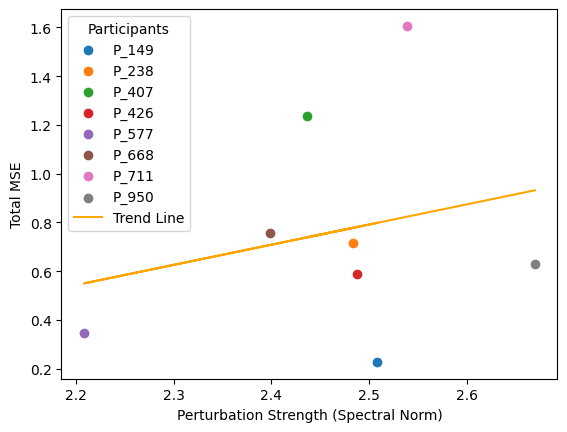

In [49]:
# plot perturbation strength vs df.loc[participant, ('pert_init', 'total')]
x = df.loc[:, ('pert', 'spectral_norm')]
y = df.loc[:, ('pert_init', 'total')]

# plt.scatter(x, y, c='red')
for i in range(len(x)):
    plt.scatter(x[i], y[i], label=participants[i])
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='orange', label='Trend Line')
plt.xlabel('Perturbation Strength (Spectral Norm)')
plt.ylabel('Total MSE')
plt.legend(title='Participants')

plt.close(fig)


In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plt.close('all')
# Create the figure and axes with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18*0.7, 5*0.7), sharey=True) # , width_ratios=[2.5, 3]

# Plot 1: Perturbation Strength vs Total MSE
x = df.loc[:, ('pert', 'spectral_norm')]
y = df.loc[:, ('pert_init', 'total')]

# Scatter plot with individual points labeled by participant
for i in range(len(x)):
    ax1.scatter(x[i], y[i], label=participants[i])

# Fit a trend line and plot it
m, b = np.polyfit(x, y, 1)
ax1.plot(x, m*x + b, color='orange', label='Linear Fit')

# Labels and legend for the first plot
ax1.set_xlabel('Perturbation Strength (Spectral Norm)')
ax1.set_ylabel('Total MSE')
ax1.legend(title='Participants', loc='upper left', title_fontproperties={'weight':'bold'})
ax1.set_title('Perturbation Strength vs Total MSE before Online Training', fontweight='bold')

# Plot 2: Recovering from Perturbation

# Modes to plot
modes = ['val', 'test', 'total']
colors = ['blue', 'green', 'red']  # Different colors for each mode
labels = ['Known Movements', 'New Movements', 'All Movements']  # Labels for each mode

# X positions for 'before' and 'after'
x_positions = np.arange(2)  # Positions for 'before' and 'after'
bar_width = 0.02  # Used for shifting

# Create a list to store custom legend handles
custom_legend_handles = []
custom_legend_handles2 = []

# Plot each mode on the same axes
for idx, (mode, color, label) in enumerate(zip(modes, colors, labels)):
    # Extract data
    means_before = []
    means_after = []

    for participant in participants:
        means_before.append(df.loc[participant, ('pert_init', mode)])
        means_after.append(df.loc[participant, ('pert_offline', mode)])

    # Convert lists to numpy arrays
    means_before = np.array(means_before)
    means_after = np.array(means_after)

    # Calculate mean and std for plotting
    mean_before = np.mean(means_before)
    mean_after = np.mean(means_after)
    std_before = np.std(means_before)
    std_after = np.std(means_after)

    # Calculate the mean of 'init' for the dotted horizontal line
    mean_init = np.mean([df.loc[participant, ('init', mode)] for participant in participants])
    std_init = np.std([df.loc[participant, ('init', mode)] for participant in participants])

    # X offset for each mode to avoid overlap
    x_offset = (idx - 1) * bar_width  # Shift each line plot slightly
    
    # Plot mean and std for each mode with error bars
    ax2.errorbar(x_positions + x_offset, 
                [mean_before, mean_after], 
                yerr=[std_before, std_after], 
                fmt='-o', 
                color=color,
                label=label)

    # Plot dotted horizontal line for each mode
    ax2.errorbar(x_positions[0] + x_offset - 0.01, 
            [mean_init], 
            yerr=[std_init], 
            fmt='-o', 
            color=color,
            label=label)
    ax2.axhline(y=mean_init, color=color, linestyle='--', linewidth=1)

    # Add custom legend handles for solid and dotted lines
    custom_legend_handles.append(Line2D([0], [0], color=color, linestyle='-', linewidth=1, label=label))
    custom_legend_handles2.append(Line2D([0], [0], color=color, linestyle='--', linewidth=1, label='Without Perturbation'))

# Set titles and labels
ax2.set_title('Total MSE Before and After Online Training on Perturbed Data', fontweight='bold')
ax2.set_ylabel('MSE ± STD')

# Adjust x-axis ticks and labels
ax2.set_xticks(x_positions)
ax2.set_xticklabels(['Before', 'After'])
ax2.set_xlabel('Online Training')

custom_legend_handles = custom_legend_handles + custom_legend_handles2
# Add legend with custom handles in the desired order and set ncol to 2
ax2.legend(handles=custom_legend_handles, loc='upper right', ncol=2, title='Test Sets', title_fontproperties={'weight':'bold'})

# Adjust layout to make sure everything fits nicely
plt.tight_layout()



plt.savefig(plot_folder / 'perturbation.png', dpi=300)
plt.close(fig)
# plt.show()


In [51]:
online = pd.read_csv(data_folder / 'online.csv')
online.set_index('Name', inplace=True)

In [52]:
for participant in participants:
    df.loc[participant, ('online', 'val')] = online.loc[participant, 'last.total_val_loss']
    df.loc[participant, ('online', 'test')] = online.loc[participant, 'last.total_test_loss']
df.loc[:, ('online', 'total')] = (df.loc[:, ('online', 'val')] * 9 + df.loc[:, ('online', 'test')] * 3) / 12


In [53]:
online = pd.read_csv(data_folder / 'pert_online.csv')
online.set_index('Name', inplace=True)
for participant in participants:
    df.loc[participant, ('pert_online', 'val')] = online.loc[participant + '_perturb', 'last.total_val_loss']
    df.loc[participant, ('pert_online', 'test')] = online.loc[participant  + '_perturb', 'last.total_test_loss']
df.loc[:, ('pert_online', 'total')] = (df.loc[:, ('pert_online', 'val')] * 9 + df.loc[:, ('pert_online', 'test')] * 3) / 12


In [9]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example symmetric matrix with 14 EMG channels
# channels = [f'emg_{i}' for i in [0, 1, 2, 4, 10, 11, 12, 13]]
channels = [f'EMG_{i}' for i in range(8)]
# Replace this matrix with your real correlation data
data = np.array([
    [0.85, 0.41, 0.53, 0.41, 0.47, 0.40, 0.44, 0.35],
    [0.41, 0.94, 0.21, 0.77, 0.19, 0.74, 0.15, 0.58],
    [0.53, 0.21, 0.70, 0.27, 0.74, 0.17, 0.53, 0.18],
    [0.41, 0.77, 0.27, 0.93, 0.26, 0.64, 0.20, 0.57],
    [0.47, 0.19, 0.74, 0.26, 0.62, 0.14, 0.69, 0.21],
    [0.40, 0.74, 0.17, 0.64, 0.14, 0.91, 0.11, 0.63],
    [0.44, 0.15, 0.53, 0.20, 0.69, 0.11, 0.64, 0.25],
    [0.35, 0.58, 0.18, 0.57, 0.21, 0.63, 0.25, 0.86],
])

# Create a DataFrame for plotting
df = pd.DataFrame(data, index=channels, columns=channels)

# Mask the upper triangle
mask = np.triu(np.ones_like(df, dtype=bool), k=1)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(df, mask=mask, cmap="coolwarm", vmin=-1, vmax=1,
            annot=True, fmt=".2f", linewidths=0.5, cbar_kws={"label": "Mean Correlation"})
plt.title("Mean EMG-to-EMG Correlation\nCorrelation to perturbed self along diagonal")
plt.xlabel("EMG Channels")
plt.ylabel("EMG Channels")
plt.tight_layout()
plt.show()

plt.savefig('emg_correlation.png', dpi=600)


In [54]:
# # interp_pert_offline
# df.set_index('participants', inplace=True, drop=False)
# mapping = pd.read_csv(data_folder / 'interp_pert_offline_mapping.csv')
# mapping.set_index('person_dir', inplace=True)
# mapping.columns = pd.MultiIndex.from_tuples([('run', 'interp_pert_offline')])
# df = df.merge(mapping, left_index=True, right_index=True)
# df.set_index(('run', 'interp_pert_offline'), inplace=True)
# 
# # val
# data = pd.read_csv(data_folder / 'interp_pert_offline_val_loss.csv')
# for key in df.index:
#     df.loc[key, ('interp_pert_offline', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
#     
# # test
# data = pd.read_csv(data_folder / 'interp_pert_offline_test_loss.csv')
# for key in df.index:
#     df.loc[key, ('interp_pert_offline', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
#     
# # total
# df.loc[:, ('interp_pert_offline', 'total')] = (df.loc[:, ('interp_pert_offline', 'val')] * 9 + df.loc[:, ('interp_pert_offline', 'test')] * 3) / 12

In [55]:
# # interp_offline
# df.set_index('participants', inplace=True, drop=False)
# mapping = pd.read_csv(data_folder / 'interp_offline_mapping.csv')
# mapping.set_index('person_dir', inplace=True)
# mapping.columns = pd.MultiIndex.from_tuples([('run', 'interp_offline')])
# df = df.merge(mapping, left_index=True, right_index=True)
# df.set_index(('run', 'interp_offline'), inplace=True)
# 
# # val
# data = pd.read_csv(data_folder / 'interp_offline_val_loss.csv')
# for key in df.index:
#     df.loc[key, ('interp_offline', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
#     
# # test
# data = pd.read_csv(data_folder / 'interp_offline_test_loss.csv')
# for key in df.index:
#     df.loc[key, ('interp_offline', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
#     
# # total
# df.loc[:, ('interp_offline', 'total')] = (df.loc[:, ('interp_offline', 'val')] * 9 + df.loc[:, ('interp_offline', 'test')] * 3) / 12

In [56]:
# comp
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'comp_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'comp')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'comp'), inplace=True)

# val
data = pd.read_csv(data_folder / 'comp_val_loss.csv')
for key in df.index:
    df.loc[key, ('comp', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'comp_test_loss.csv')
for key in df.index:
    df.loc[key, ('comp', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('comp', 'total')] = (df.loc[:, ('comp', 'val')] * 9 + df.loc[:, ('comp', 'test')] * 3) / 12

In [57]:
# pert_comp
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'pert_comp_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'pert_comp')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'pert_comp'), inplace=True)

# val
data = pd.read_csv(data_folder / 'pert_comp_val_loss.csv')
for key in df.index:
    df.loc[key, ('pert_comp', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'pert_comp_test_loss.csv')
for key in df.index:
    df.loc[key, ('pert_comp', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('pert_comp', 'total')] = (df.loc[:, ('pert_comp', 'val')] * 9 + df.loc[:, ('pert_comp', 'test')] * 3) / 12

In [58]:
# comp_interp
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'comp_interp_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'comp_interp')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'comp_interp'), inplace=True)

# val
data = pd.read_csv(data_folder / 'comp_interp_val_loss.csv')
for key in df.index:
    df.loc[key, ('comp_interp', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'comp_interp_test_loss.csv')
for key in df.index:
    df.loc[key, ('comp_interp', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('comp_interp', 'total')] = (df.loc[:, ('comp_interp', 'val')] * 9 + df.loc[:, ('comp_interp', 'test')] * 3) / 12

In [59]:
# pert_comp_interp
df.set_index('participants', inplace=True, drop=False)
mapping = pd.read_csv(data_folder / 'pert_comp_interp_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.MultiIndex.from_tuples([('run', 'pert_comp_interp')])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index(('run', 'pert_comp_interp'), inplace=True)

# val
data = pd.read_csv(data_folder / 'pert_comp_interp_val_loss.csv')
for key in df.index:
    df.loc[key, ('pert_comp_interp', 'val')] = data.loc[len(data)-1, f'{key} - total_val_loss']
    
# test
data = pd.read_csv(data_folder / 'pert_comp_interp_test_loss.csv')
for key in df.index:
    df.loc[key, ('pert_comp_interp', 'test')] = data.loc[len(data)-1, f'{key} - total_test_loss']
    
# total
df.loc[:, ('pert_comp_interp', 'total')] = (df.loc[:, ('pert_comp_interp', 'val')] * 9 + df.loc[:, ('pert_comp_interp', 'test')] * 3) / 12

In [60]:

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18*0.7, 5*0.7), sharey=True)

# Set index
df.set_index('participants', inplace=True, drop=False)

# Mode to plot
mode = 'total'

# Colors and labels for the bars
# 3 shades of blue: colors = ['#1f77b4', '#3399ff', '#99ccff']
# red ['#8B0000', '#FF4500', '#FFA07A']

colors = {
    'comp': '#1f77b4',
    'comp_interp': '#3399ff',
    'online': '#99ccff',
    'pert_comp': '#1f77b4',
    'pert_comp_interp':  '#3399ff',
    'pert_online':  '#99ccff'
}
# colors = {
#     'comp': '#8B0000',  # Dark red
#     'comp_interp': '#FF4500',  # Medium red
#     'online': '#FFA07A',  # Light red
#     'pert_comp': '#8B0000',  # Dark red
#     'pert_comp_interp':  '#FF4500',  # Medium red
#     'pert_online':  '#FFA07A'  # Light red
# }


labels = {
    'comp': 'Offline Stream',    # Offline Stream
    'comp_interp': 'Interpolated Offline Stream', # Interpolated Offline Stream
    'online': 'True Online', # True Online
    'pert_comp': 'Offline Stream', # Offline Stream
    'pert_comp_interp': 'Interpolated Offline Stream', # Interpolated Offline Stream
    'pert_online': 'True Online' # True Online
}

# X positions for bars
x_positions = np.arange(3)  # Number of bars per group
bar_width = 0.5  # Width of bars

# Adjust the positions to group bars
group1_positions = x_positions * bar_width * 1.5
group2_positions = x_positions * bar_width * 1.5 + bar_width * 3  # Shift the second group right

# Extract and plot data for 'after' values in the first subplot (Not Perturbed)
for idx, (key, color) in enumerate(colors.items()):
    if 'pert' not in key:  # Filter for not perturbed data
        means_after = [df.loc[participant, (key, mode)] for participant in participants]
        mean_after = np.mean(means_after)

        # Determine the x position for the bar
        x_pos = group1_positions[idx % 3]
        
        # Plot bars
        ax1.bar(x_pos, mean_after, width=bar_width, color=color, label=labels[key])

# Extract and plot data for 'after' values in the second subplot (Perturbed)
for idx, (key, color) in enumerate(colors.items()):
    if 'pert' in key:  # Filter for perturbed data
        means_after = [df.loc[participant, (key, mode)] for participant in participants]
        mean_after = np.mean(means_after)

        # Determine the x position for the bar
        x_pos = group2_positions[idx % 3]
        
        # Plot bars
        ax2.bar(x_pos, mean_after, width=bar_width, color=color, label=labels[key])

# Calculate the mean of 'init' for the dotted horizontal line
mean_init = np.mean([df.loc[participant, ('init', mode)] for participant in participants])

# # Plot dotted horizontal line for the mean of 'init' and label it in both subplots
# for ax in [ax1, ax2]:
#     line = ax.axhline(y=mean_init, color='brown', linestyle='--', linewidth=1, label='Before Online Training')
#     ax.text(
#         x=-0.115,
#         y=mean_init * 1.01,  # Slightly above the line
#         s='Before Online Training', 
#         color='brown', 
#         fontsize=12, 
#         ha='left', 
#         va='bottom')

# Set titles, labels, and adjust other plot properties
ax1.set_title('Total MSE After Online Training on Regular Data', fontweight='bold')
ax1.set_ylabel('Total MSE')
ax1.set_xticks(group1_positions)
ax1.set_xticklabels([labels[key] for key in colors if 'pert' not in key], rotation=0)
ax1.set_ylim(0, 0.14)  # Increase y-limit by 10%
# ax1.set_xlabel('Training Mode')

ax2.set_title('Total MSE After Online Training on Perturbed Data', fontweight='bold')
ax2.set_xticks(group2_positions)
ax2.set_xticklabels([labels[key] for key in colors if 'pert' in key], rotation=0)
# ax2.set_ylim(0, 0.14)  # Increase y-limit by 10%
# ax2.set_xlabel('Training Mode')

# Adjust layout
plt.tight_layout()

plt.savefig(plot_folder / 'true_online.png', dpi=300)
plt.close(fig)


In [61]:
# does the order matter?
# participants = ['P_149', 'P_238', 'P_407', 'P_426', 'P_577', 'P_668', 'P_711', 'P_950']
# data_folder = Path('/Users/jg/Desktop/upper_limb/paper_data')
#make df using the participants as index
df = pd.DataFrame(index=participants) #, columns=pd.MultiIndex.from_product([['init', 'offline'], ['val', 'test', 'total']]))
df.loc[:, 'participants'] = df.index


In [62]:
# offline
# df.set_index('participants', inplace=True, drop=False)
df.index.set_names('participants', inplace=True)
mapping = pd.read_csv(data_folder / 'offline_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.Index(['run'])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index('run', inplace=True)

# val
data = pd.read_csv(data_folder / 'offline_val_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_val_loss']
    
val_df = df.copy()

# test
data = pd.read_csv(data_folder / 'offline_test_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_test_loss']

test_df = df.copy()
test_df.drop(columns='participants', inplace=True)
val_df.drop(columns='participants', inplace=True)
# total
total_df = (val_df * 9 + test_df * 3) / 12
total_df_offline = total_df.copy()
val_df_offline = val_df.copy()
test_df_offline = test_df.copy()

In [63]:
df = pd.DataFrame(index=participants) #, columns=pd.MultiIndex.from_product([['init', 'offline'], ['val', 'test', 'total']]))
df.loc[:, 'participants'] = df.index

In [64]:
# inverse
# df.set_index('participants', inplace=True, drop=False)
df.index.set_names('participants', inplace=True)
mapping = pd.read_csv(data_folder / 'inverse_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.Index(['run'])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index('run', inplace=True)

# val
data = pd.read_csv(data_folder / 'inverse_val_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_val_loss']
    
val_df = df.copy()

# test
data = pd.read_csv(data_folder / 'inverse_test_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_test_loss']

test_df = df.copy()
test_df.drop(columns='participants', inplace=True)
val_df.drop(columns='participants', inplace=True)
# total
total_df = (val_df * 9 + test_df * 3) / 12
total_df_inverse = total_df.copy()
val_df_inverse = val_df.copy()
test_df_inverse = test_df.copy()


In [65]:
print(f'Old First: {total_df_inverse.mean(axis=0).iloc[-1]}')
print(f'New First: {total_df_offline.mean(axis=0).iloc[-1]}')

Old First: 0.0682202999887522
New First: 0.07081200249376703


In [66]:
# import matplotlib.pyplot as plt
# 
# # Create a figure and two subplots
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
# # Set x-axis limits and scale
# num_ticks = 7
# tick_positions = np.linspace(0, len(total_df_offline.mean(axis=0)) - 1, num_ticks, dtype=int)
# tick_labels = [int(i * 360 / (len(total_df_offline.mean(axis=0)) - 1)) for i in tick_positions]
# 
# # Plot 1: Validation and Test Loss
# ax1.plot(val_df_offline.mean(axis=0), label='Val Loss: New First', color='blue')
# ax1.plot(val_df_inverse.mean(axis=0), label='Val Loss: Known First', color='lightblue')
# ax1.plot(test_df_offline.mean(axis=0), label='Test Loss: New First', color='green')
# ax1.plot(test_df_inverse.mean(axis=0), label='Test Loss: Known First', color='lightgreen')
# ax1.set_ylabel('MSE')
# ax1.set_title('Validation and Test Loss')
# ax1.set_xticks(tick_positions)
# ax1.set_xticklabels(tick_labels)
# ax1.set_xlabel('Time [seconds]')
# ax1.legend()
# 
# # Plot 2: Total Loss
# ax2.plot(total_df_offline.mean(axis=0), label='Total Loss: New First', color='red')
# ax2.plot(total_df_inverse.mean(axis=0), label='Total Loss: Known First', color='orange')
# ax2.set_title('Total Loss')
# ax2.legend()
# 
# ax2.set_xticks(tick_positions)
# ax2.set_xticklabels(tick_labels)
# ax2.set_xlabel('Time [seconds]')
# 
# # Adjust layout
# plt.tight_layout()
# 
# 
# 
# # Show the plot
# plt.show()


In [67]:
# slower initial training

In [68]:
# best
# df.set_index('participants', inplace=True, drop=False)
df = pd.DataFrame(index=participants) #, columns=pd.MultiIndex.from_product([['init', 'offline'], ['val', 'test', 'total']]))
df.loc[:, 'participants'] = df.index
df.index.set_names('participants', inplace=True)
mapping = pd.read_csv(data_folder / 'best_mapping.csv')
mapping.set_index('person_dir', inplace=True)
mapping.columns = pd.Index(['run'])
df = df.merge(mapping, left_index=True, right_index=True)
df.set_index('run', inplace=True)

# val
data = pd.read_csv(data_folder / 'best_val_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_val_loss']
    
val_df = df.copy()

# test
data = pd.read_csv(data_folder / 'best_test_loss.csv')
for key in df.index:
    for i in data.index:
        df.loc[key, i] = data.loc[i, f'{key} - total_test_loss']

test_df = df.copy()
test_df.drop(columns='participants', inplace=True)
val_df.drop(columns='participants', inplace=True)
# total
total_df = (val_df * 9 + test_df * 3) / 12
total_df_best = total_df.copy()
val_df_best = val_df.copy()
test_df_best = test_df.copy()

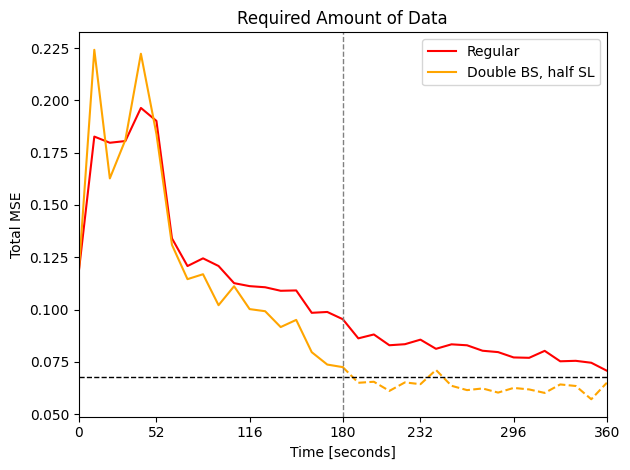

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Subsample the data
subsampled_best = total_df_best.mean(axis=0).iloc[::2].copy()
subsampled_best.index = range(0, len(subsampled_best))

# Compute the last value of 'Regular'
last_value_regular = total_df_offline.mean(axis=0).iloc[-1]
last_value_best = total_df_best.mean(axis=0).iloc[-1]

# Calculate the position corresponding to 180 seconds
x_180 = 180 * len(total_df_offline.mean(axis=0)) / 360

# Prepare x and y values
x_values = np.arange(len(subsampled_best))
y_values = subsampled_best

# Find indices around 180 seconds
idx_180 = np.searchsorted(x_values, x_180, side='left')

# Split the data into segments
x_before = x_values[:idx_180]
y_before = y_values.iloc[:idx_180]

x_after = x_values[idx_180 - 1:]
y_after = y_values.iloc[idx_180 - 1:]

# Plot the data
plt.plot(total_df_offline.mean(axis=0), label='Regular', color='red')

# Plot the 'Double BS, half SL' data with dashed line after 180 seconds
plt.plot(x_before, y_before, linestyle='-', color='orange', label='Double BS, half SL')
plt.plot(x_after, y_after, linestyle='--', color='orange')

# Set title and labels
plt.title('Required Amount of Data')
plt.ylabel('Total MSE')  # Label y-axis
plt.xlabel('Time [seconds]')  # Label x-axis

# Set x-axis limits and scale
num_ticks = 7
tick_positions = np.linspace(0, len(total_df_offline.mean(axis=0)) - 1, num_ticks, dtype=int)
tick_labels = [int(i * 360 / (len(total_df_offline.mean(axis=0)) - 1)) for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels)
plt.xlim(0, len(total_df_offline.mean(axis=0)) - 1)  # Set x-axis limit based on the data length

# Add vertical line at 180 seconds
plt.axvline(x=tick_positions[3], color='gray', linestyle='--', linewidth=1)

# Add horizontal line at the last value of 'Regular'
plt.axhline(y=(last_value_regular + last_value_best) / 2, color='black', linestyle='--', linewidth=1)

# Add legend
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.close(fig)

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18*0.7, 5*0.7), sharey=True)
# Set x-axis limits and scale
num_ticks = 7
tick_positions = np.linspace(0, len(total_df_offline.mean(axis=0)) - 1, num_ticks, dtype=int)
tick_labels = [int(i * 360 / (len(total_df_offline.mean(axis=0)) - 1)) for i in tick_positions]

# Plot 1: Validation and Test Loss
ax1.plot(val_df_offline.mean(axis=0), label='Known Movements - New First', color='blue', linestyle='-')
ax1.plot(val_df_inverse.mean(axis=0), label='Known Movements - New Last', color='blue', linestyle='--')
ax1.plot(test_df_offline.mean(axis=0), label='New Movements - New First', color='green')
ax1.plot(test_df_inverse.mean(axis=0), label='New Movements - New Last', color='green', linestyle='--')
ax1.set_ylabel('MSE')
ax1.set_title('Optimal Movement Ordering', fontweight='bold')
ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.set_xlim(0, len(total_df_offline.mean(axis=0)) - 1)  # Set x-axis limit based on the data length
ax1.legend(title='Test Set - Movement Order', loc='upper right', title_fontproperties={'weight':'bold'})
ax1.set_xlabel('Online Training Time [seconds]')  # Label x-axis


# Prepare x and y values for Plot 2
subsampled_best = total_df_best.mean(axis=0).iloc[::2].copy()
subsampled_best.index = range(0, len(subsampled_best))

# Compute the last value of 'Regular'
last_value_regular = total_df_offline.mean(axis=0).iloc[-1]
last_value_best = total_df_best.mean(axis=0).iloc[-1]

# Calculate the position corresponding to 180 seconds
x_180 = 180 * len(total_df_offline.mean(axis=0)) / 360

# Prepare x and y values
x_values = np.arange(len(subsampled_best))
y_values = subsampled_best

# Find indices around 180 seconds
idx_180 = np.searchsorted(x_values, x_180, side='left')

# Split the data into segments
x_before = x_values[:idx_180]
y_before = y_values.iloc[:idx_180]

x_after = x_values[idx_180 - 1:]
y_after = y_values.iloc[idx_180 - 1:]

# Plot 2: Total Loss with additional features
ax2.plot(total_df_offline.mean(axis=0), label='All Movements - Standard Params', color='red')

# Plot the 'Double BS, half SL' data with dashed line after 180 seconds
ax2.plot(x_before, y_before, linestyle='-', color='orange', label='All Movements - Double BS, Half SL')
ax2.plot(x_after, y_after, linestyle='--', color='orange')

# Set title and labels
ax2.set_title('Necessary Online Training Time', fontweight='bold')
# ax2.set_ylabel('Total MSE')  # Label y-axis
ax2.set_xlabel('Online Training Time [seconds]')  # Label x-axis

# Set x-axis limits and scale
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels)
ax2.set_xlim(0, len(total_df_offline.mean(axis=0)) - 1)  # Set x-axis limit based on the data length

# Add vertical line at 180 seconds
ax2.axvline(x=tick_positions[3], color='gray', linestyle='--', linewidth=1)

# Add horizontal line at the last value of 'Regular'
# ax2.axhline(y=(last_value_regular + last_value_best) / 2, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=last_value_regular, color='black', linestyle='--', linewidth=1)

# Add legend
ax2.legend(title='  Test Set - Parameters', loc='upper right', title_fontproperties={'weight':'bold'})

# Adjust layout
plt.tight_layout()

plt.savefig(plot_folder / 'data.png', dpi=300)
plt.close(fig)


In [71]:
import argparse
import math
import os
import yaml
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import numpy as np
from os.path import join
import wandb
import multiprocessing

from helpers.predict_utils import Config, get_data, train_model, rescale_data, evaluate_model
from helpers.models import TimeSeriesRegressorWrapper


perturb = False
allow_tf32 = True
person_dir = 'P_577'
intact_hand = 'Left'
visualize = False
config_name = 'modular_online'
# test_recordings = ['indexFlDigitsEx']

sampling_frequency = 60
experiment_name = 'perturb' if perturb else 'non_perturb'

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using CUDA')
#
#     # List available GPUs
#     if multi_gpu:
#         n_gpus = torch.cuda.device_count()
#         print(f'Number of available GPUs: {n_gpus}')
#         for i in range(n_gpus):
#             print(f'GPU{i}: {torch.cuda.get_device_name(i)}')

# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print('Using MPS')
else:
    device = torch.device("cpu")
    print('Using CPU')

if allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
    print('TF32 enabled')

with open(join('data', person_dir, 'configs', f'{config_name}.yaml'), 'r') as file:
    wandb_config = yaml.safe_load(file)
    config = Config(wandb_config)

data_dirs = [join('data', person_dir, 'recordings', recording, 'experiments', '1') for recording in
             config.recordings]

test_dirs = [join('data', person_dir, 'recordings', recording, 'experiments', '1') for recording in
             config.test_recordings] if config.test_recordings is not None else []
perturb_file = join('data', person_dir, 'online_trials', experiment_name,
                    'perturber.npy')


trainsets, valsets, combined_sets, testsets = get_data(config, data_dirs, intact_hand, visualize=visualize, test_dirs=test_dirs, perturb_file=perturb_file)

config.person_dir = person_dir
config.intact_hand = intact_hand
config.experiment_name = experiment_name
config.perturb = perturb
config.wandb_project = 'study_participants_online'
config.wandb_mode = 'disabled'
if perturb:
    config.name = config.name + '_perturb'


wandb.init(mode=config.wandb_mode, project=config.wandb_project, name=config.name, config=config)
config = wandb.config

model = TimeSeriesRegressorWrapper(device=device, input_size=len(config.features),
                                   output_size=len(config.targets),
                                   **config)
model.to('cpu')
model.load(join('data', person_dir, 'online_trials', experiment_name, 'models', f'{person_dir}-online_last.pt'))
model.to(device)
model.eval()

test_pred = model.predict(testsets[2], config.features, config.targets).squeeze(0)
val_pred = model.predict(valsets[4], config.features, config.targets).squeeze(0)

model.to('cpu')
model.load(join('data', person_dir, 'online_trials', experiment_name, 'models', f'{person_dir}-online_0.pt'))
model.to(device)
model.eval()
test_pred_before = model.predict(testsets[2], config.features, config.targets).squeeze(0)
val_pred_before = model.predict(valsets[4], config.features, config.targets).squeeze(0)




Using CPU
TF32 enabled


/Users/jg/projects/biomech/biomech_PCP/helpers/models.py:542: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path, map_location=torch.de

In [72]:

import matplotlib.pyplot as plt
import pandas as pd

# Assuming indices and targets are already defined as per your setup
indices = [0, 1]
targets = [config.targets[i] for i in indices]

# Update indices for testsets and valsets
for testset in testsets:
    testset.index = pd.Index(range(len(testset)))
for valset in valsets:
    valset.index = pd.Index(range(len(valset)))

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18*0.7, 5*0.7), sharey=True)

# X-axis values for the plots
x_values = range(len(testsets[2][targets].values))

# Plot on the first subplot
ax1.plot(x_values, testsets[2][targets].values[:, 0], label='Target - Index Joint', color='blue')
ax1.plot(x_values, test_pred_before[:, indices[0]], label='Prediction - Index Joint', color='blue', linestyle='--')
ax1.plot(x_values, testsets[2][targets].values[:, 1], label='Target - Middle Finger Joint', color='green')
ax1.plot(x_values, test_pred_before[:, indices[1]], label='Prediction - Middle Finger Joint', color='green', linestyle='--')
ax1.set_xlabel('Time [seconds]')  # Original x-axis label
ax1.set_ylabel('Normalized Angle')  # y-axis label
ax1.set_title('IndexFlexDigitsExtend - Trajectories Before Online Training', fontweight='bold')  # Title
# Set x-axis ticks and labels for ax1
ax1.set_xticks(range(0, len(x_values)+1, 60))  # Set ticks based on the length of x_values
ax1.set_xticklabels([f'{i}' for i in range(len(x_values)//60+1)])  # Scale labels from 0 to 6

# Plot on the second subplot
ax2.plot(x_values, testsets[2][targets].values[:, 0], label='Target - Index Joint', color='blue')
ax2.plot(x_values, test_pred[:, indices[0]], label='Prediction - Index Joint', color='blue', linestyle='--')
ax2.plot(x_values, testsets[2][targets].values[:, 1], label='Target - Middle Finger Joint', color='green')
ax2.plot(x_values, test_pred[:, indices[1]], label='Prediction - Middle Finger Joint', color='green', linestyle='--')
ax2.set_xlabel('Time [seconds]')  # Original x-axis label
# ax2.set_ylabel('Normalized Angle')  # y-axis label (shared with ax1)
ax2.set_title('IndexFlexDigitsExtend - Trajectories After Online Training', fontweight='bold')  # Title
ax2.legend(loc='upper right')
# Set x-axis ticks and labels for ax2
ax2.set_xticks(range(0, len(x_values)+1, 60))  # Set ticks based on the length of x_values
ax2.set_xticklabels([f'{i}' for i in range(len(x_values)//60+1)])  # Scale labels from 0 to 6

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(plot_folder / 'trajectory_test.png', dpi=300)
plt.close(fig)

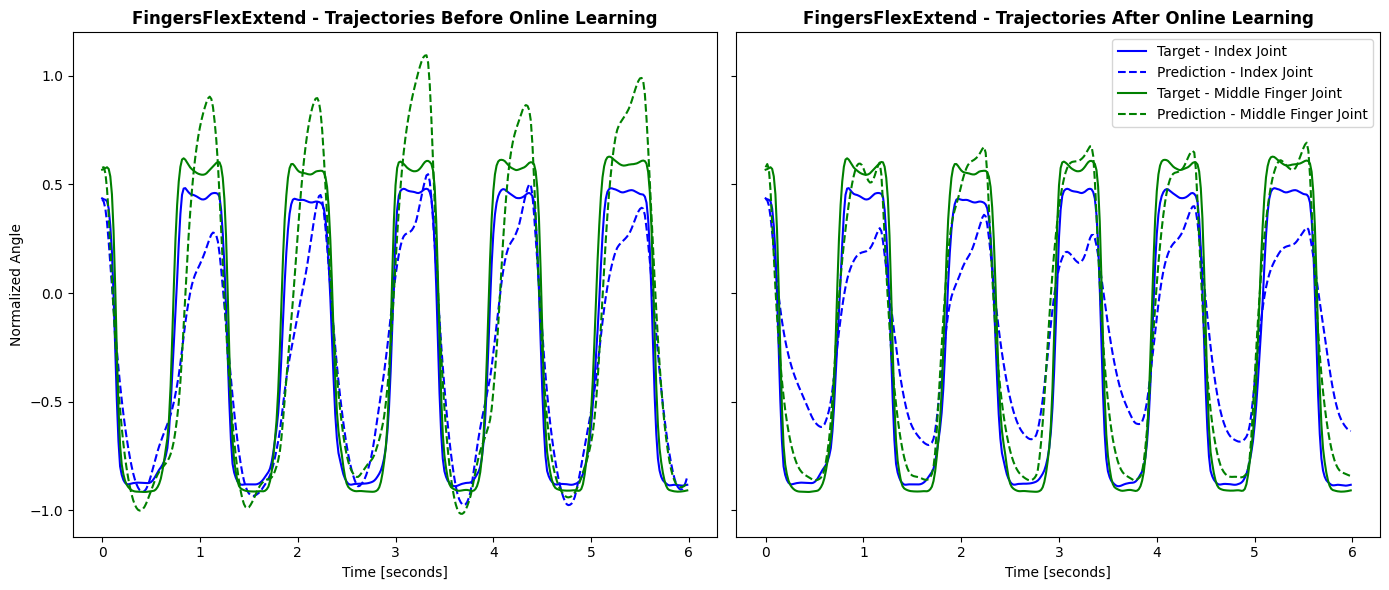

In [211]:

import matplotlib.pyplot as plt
import pandas as pd

# Assuming indices and targets are already defined as per your setup
indices = [0, 1]
targets = [config.targets[i] for i in indices]

# Update indices for testsets and valsets
for testset in testsets:
    testset.index = pd.Index(range(len(testset)))
for valset in valsets:
    valset.index = pd.Index(range(len(valset)))

# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18*0.7, 5*0.7), sharey=True)

# X-axis values for the plots
x_values = range(len(testsets[2][targets].values))

# Plot on the first subplot
ax1.plot(x_values, valsets[4][targets].values[:, 0], label='Target - Index Joint', color='blue')
ax1.plot(x_values, val_pred_before[:, indices[0]], label='Prediction - Index Joint', color='blue', linestyle='--')

ax1.plot(x_values, valsets[4][targets].values[:, 1], label='Target - Middle Finger Joint', color='green')
ax1.plot(x_values, val_pred_before[:, indices[1]], label='Prediction - Middle Finger Joint', color='green', linestyle='--')
ax1.set_xlabel('Time [seconds]')  # Original x-axis label
ax1.set_ylabel('Normalized Angle')  # y-axis label
ax1.set_title('FingersFlexExtend - Trajectories Before Online Learning', fontweight='bold')  # Title
# Set x-axis ticks and labels for ax1
ax1.set_xticks(range(0, len(x_values)+1, 60))  # Set ticks based on the length of x_values
ax1.set_xticklabels([f'{i}' for i in range(len(x_values)//60+1)])  # Scale labels from 0 to 6

# Plot on the second subplot
ax2.plot(x_values, valsets[4][targets].values[:, 0], label='Target - Index Joint', color='blue')
ax2.plot(x_values, val_pred[:, indices[0]], label='Prediction - Index Joint', color='blue', linestyle='--')

ax2.plot(x_values, valsets[4][targets].values[:, 1], label='Target - Middle Finger Joint', color='green')
ax2.plot(x_values, val_pred[:, indices[1]], label='Prediction - Middle Finger Joint', color='green', linestyle='--')
ax2.set_xlabel('Time [seconds]')  # Original x-axis label
# ax2.set_ylabel('Normalized Angle')  # y-axis label (shared with ax1)
ax2.set_title('FingersFlexExtend - Trajectories After Online Learning', fontweight='bold')  # Title
ax2.legend(loc='upper right')
# Set x-axis ticks and labels for ax2
ax2.set_xticks(range(0, len(x_values)+1, 60))  # Set ticks based on the length of x_values
ax2.set_xticklabels([f'{i}' for i in range(len(x_values)//60+1)])  # Scale labels from 0 to 6

# Adjust layout to prevent overlap
plt.tight_layout()

plt.savefig(plot_folder / 'trajectory_val.png', dpi=300)
plt.close(fig)


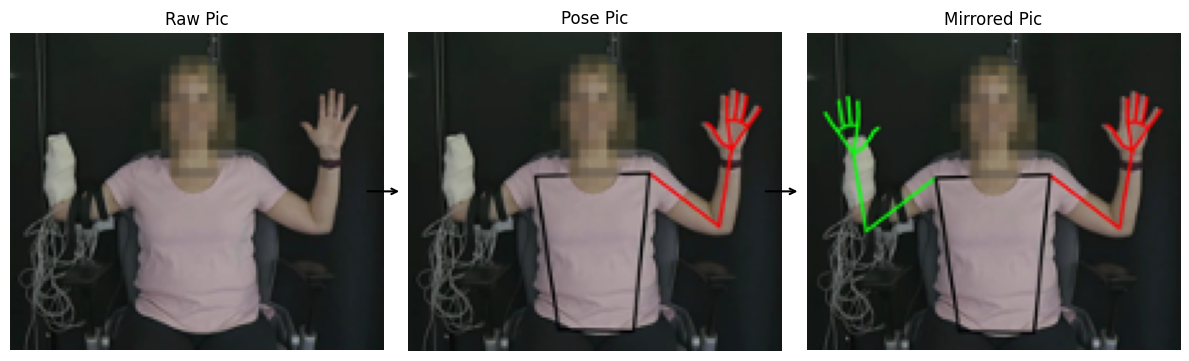

In [75]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load images
raw_pic = Image.open(data_folder / 'raw_pic.png')
pose_pic = Image.open(data_folder / 'pose_pic.png')
mirrored_pic = Image.open(data_folder / 'mirrored_pic.png')


# Create a figure and axes
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Plot images
ax[0].imshow(raw_pic)
ax[0].set_title('Raw Pic')
ax[0].axis('off')

ax[1].imshow(pose_pic)
ax[1].set_title('Pose Pic')
ax[1].axis('off')

ax[2].imshow(mirrored_pic)
ax[2].set_title('Mirrored Pic')
ax[2].axis('off')

# Draw arrows
arrowprops = dict(facecolor='black', arrowstyle='->', lw=1.5)
ax[0].annotate('', xy=(1.05, 0.5), xytext=(0.95, 0.5),
               arrowprops=arrowprops, xycoords='axes fraction', textcoords='axes fraction')

ax[1].annotate('', xy=(1.05, 0.5), xytext=(0.95, 0.5),
               arrowprops=arrowprops, xycoords='axes fraction', textcoords='axes fraction')

# Adjust layout
plt.tight_layout()
plt.show()

